In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
# import sklearn
import pretty_midi
from tqdm import tqdm
import random 
import re
import collections 
import pathlib 
import glob 
warnings.simplefilter("ignore", UserWarning)

# Getting data 

The Maestro dataset is a collection of over 200 hours of classical piano performances in MIDI and audio formats, spanning a wide range of musical styles and composers. It includes annotations such as tempo, dynamics, and pedal usage, and is commonly used for machine learning, music information retrieval, and computer music research. It can be downloaded for non-commercial use from the Magenta project website.

https://magenta.tensorflow.org/datasets/maestro

In [3]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

midi_paths = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(midi_paths))

59243107/59243107 [==============================] - 8s 0us/step
Number of files: 1282


In [4]:
sample_file = midi_paths[0]
sample_object = pretty_midi.PrettyMIDI(sample_file)

# Preprocessing our data

Right now our data is a bunch of MIDI files stored in our directory, but we need to transform these files into something the neural network can consume. We will preprocess the data with the following steps...

1. collect the file paths for each MIDI file 
2. load the MIDI file and extract the notes 
3. vectorizes the notes into arrays that the NN can understand 
4. turn the list of arrays for each song into a uniform input and output sequences for the LSTM model to predict 

In [5]:

def midi_to_notes(midi_object):
  # source - https://www.tensorflow.org/tutorials/audio/music_generation
  instrument = midi_object.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start
  
  for note in sorted_notes:
    start = note.start
    end = note.end
    pitch = note.pitch
    notes['pitch'].append(pitch)
    notes['note_name'].append(pretty_midi.note_number_to_name(pitch)) # e.g 50 -> D3
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

midi_to_notes(sample_object)


,pitch,note_name,start,end,step,duration
0,77,F5,0.994792,1.087240,0.000000,0.092448
1,49,C#3,0.998698,1.401042,0.003906,0.402344
2,73,C#5,1.108073,1.173177,0.109375,0.065104
3,68,G#4,1.207031,1.268229,0.098958,0.061198
4,73,C#5,1.315104,1.375000,0.108073,0.059896
...,...,...,...,...,...,...
2230,37,C#2,208.315104,211.058594,0.707031,2.743490
2231,61,C#4,208.397135,211.037760,0.082031,2.640625
2232,65,F4,208.453125,211.044271,0.055990,2.591146
2233,68,G#4,208.510417,211.057292,0.057292,2.546875


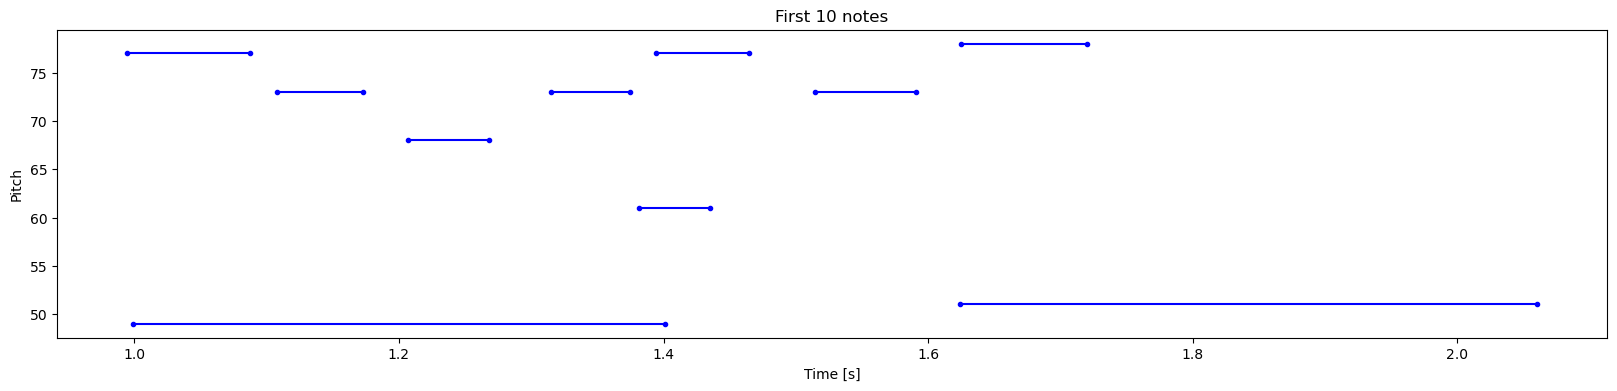

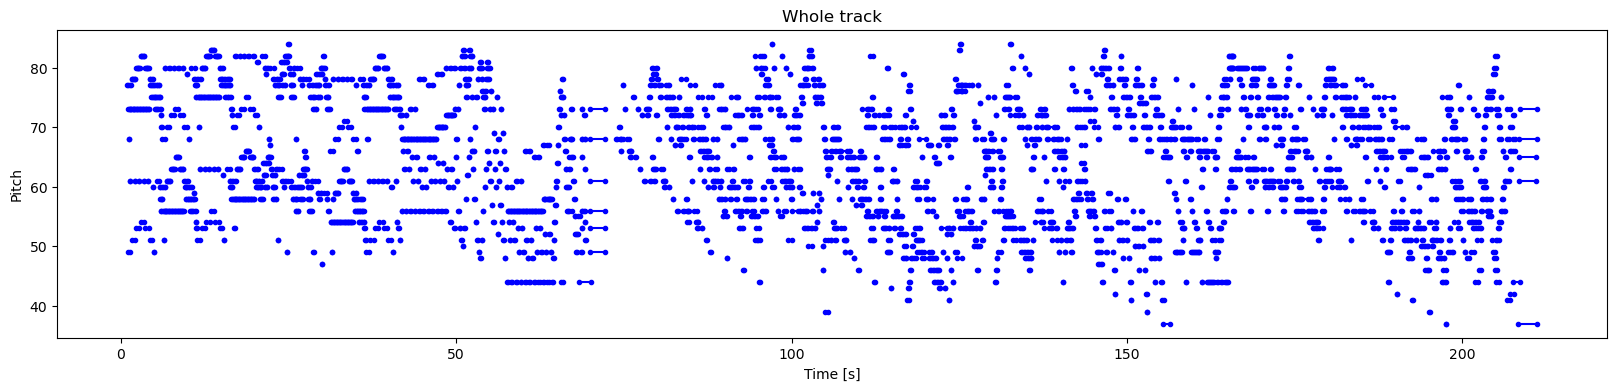

In [6]:
def plot_piano_roll(notes: pd.DataFrame, count: int = None):
  """Used to visualize the notes in a track."""
  # source - https://www.tensorflow.org/tutorials/audio/music_generation

  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

plot_piano_roll(midi_to_notes(sample_object),count=10)
plot_piano_roll(midi_to_notes(sample_object))

In [7]:
def get_song_data(file_path):
    """Returns song name, length, number of notes, and vectorized notes for an INDIVIDUAL song"""
    midi_object = pretty_midi.PrettyMIDI(file_path)

    # length of song in seconds
    song_length = midi_object.get_end_time()

    # name of song
    song_name = os.path.basename(file_path)

    # notes df 
    notes_df = midi_to_notes(midi_object)
    num_notes = len(notes_df)

    # sequences of notes in array form e.g [50, 51, 52, 53, 54]
    vectorized_notes = notes_df[['pitch','step','duration']].values

    return song_name, song_length, num_notes, vectorized_notes
    
get_song_data(sample_file)

('ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--1.midi',
 211.10807291666666,
 2235,
 array([[7.70000000e+01, 0.00000000e+00, 9.24479167e-02],
        [4.90000000e+01, 3.90625000e-03, 4.02343750e-01],
        [7.30000000e+01, 1.09375000e-01, 6.51041667e-02],
        ...,
        [6.50000000e+01, 5.59895833e-02, 2.59114583e+00],
        [6.80000000e+01, 5.72916667e-02, 2.54687500e+00],
        [7.30000000e+01, 7.29166667e-02, 2.46614583e+00]]))

In [15]:
def get_data(midi_paths):
    data = []
    for path in tqdm(midi_paths):
        try:
            song_name, song_length, num_notes, vectorized_notes = get_song_data(path)
            song_data = [song_name, song_length, num_notes, vectorized_notes]
            
            # we only want songs that are less than 5 minutes
            if song_length < 300: 
                data.append(song_data)
            else:
                continue
        except:
            print(f"Error with {path}")

    df = pd.DataFrame(data, columns=["song name", "song length (seconds)", "number of notes", "vectorized_notes"])
    print(df.head())

    all_notes = df['vectorized_notes']

    return all_notes,df

all_notes, df = get_data(midi_paths)

100%|██████████| 1282/1282 [05:23<00:00,  3.97it/s]

                                           song name  song length (seconds)  \
0  ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_20...             211.108073   
1  ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_20...             275.855469   
2  ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_20...             208.595052   
3  ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_R1_20...             276.880208   
4  ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_20...             119.156250   

   number of notes                                   vectorized_notes  
0             2235  [[77.0, 0.0, 0.09244791666666663], [49.0, 0.00...  
1             4231  [[63.0, 0.0, 0.078125], [75.0, 0.0052083333333...  
2             2280  [[77.0, 0.0, 0.10416666666666674], [49.0, 0.01...  
3             2734  [[68.0, 0.0, 0.02604166666666674], [67.0, 0.03...  
4             2306  [[56.0, 0.0, 0.03515625], [80.0, 0.0, 0.169270...  


This dataset is smaller than the entire dataset because we only want songs that are less than 5 minutes we're doing this to reduce the size of the dataset


### Creating input and output sequences

In [16]:
from tensorflow.keras.utils import to_categorical

def create_input_output(data, sequence_length=64):
    input_seqs = []
    output_notes = []

    for song in data:
        for i in range(0, len(song) - sequence_length):
            input_seq = song[i:i+sequence_length]
            output_note = song[i+sequence_length]

            input_seqs.append(input_seq)
            output_notes.append(output_note)

    input_seqs = np.array(input_seqs)
    output_seqs = np.array([
        # to_categorical(np.array([note[0] for note in output_notes])), # pitch
        np.array([note[0] for note in output_notes]), # pitch
        np.array([note[1] for note in output_notes]), # step
        np.array([note[2] for note in output_notes]) # duration
    ]).transpose()

    return input_seqs, output_seqs

input_seqs, output_seqs = create_input_output(all_notes)

print("Input Sequences")
print(type(input_seqs))
print(input_seqs.shape)

print("Output Sequences")
print(type(output_seqs))
print(output_seqs.shape)

del all_notes

Input Sequences
<class 'numpy.ndarray'>
(904972, 64, 3)
Output Sequences
<class 'numpy.ndarray'>
(904972, 3)


### Creating a TF dataset

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(input_seqs, output_seqs, test_size=0.2)

# # Create tf.data.Dataset objects for the train and test sets
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# # Set batch size and other options, if desired
# batch_size = 32
# train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


# Designing the model

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Dropout, Input
from keras.models import Sequential

In [21]:
# create a LSTM model using input_seqs and output_seqs

input_shape = (64, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = {
  'pitch': tf.keras.layers.Dense(128, activation="softmax",name='pitch')(x),
  'step': tf.keras.layers.Dense(1, activation="linear",name='step')(x),
  'duration': tf.keras.layers.Dense(1, activation="linear",name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': "sparse_categorical_crossentropy",
      'step': "mse",
      'duration': "mse",
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_2[0][0]']                
                                                                                            

Fine tuning

In [23]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

epochs = 100

batch_size = 32

# create labels for each output
pitch_labels = y_train[:, 0].astype(int)
step_labels = y_train[:, 1].reshape(-1, 1)
duration_labels = y_train[:, 2].reshape(-1, 1)

# batch size
batch_size = 32

# train the model
history = model.fit(
    x=x_train,
    y={"pitch": pitch_labels, "step": step_labels, "duration": duration_labels}, 
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

# save model after running
model.save('model.h5')


Epoch 1/100
  257/22625 [..............................] - ETA: 15:34 - loss: 0.3080 - duration_loss: 0.0827 - pitch_loss: 4.0444 - step_loss: 0.0231

KeyboardInterrupt: 

# Training the model


Analyzing its accuracy over time

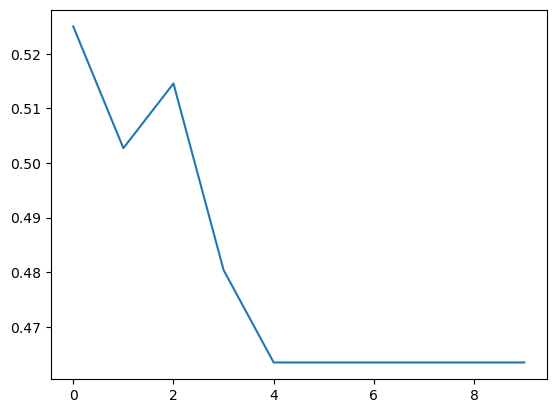

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# Generate New Music!

In [ ]:
# from keras.models import load_model

# model = load_model('model.h5')
# # model.summary()

# test = tf.data.TFRecordDataset("testing_data.tfrecord")
# print(test)

2023-04-25 13:56:53.967139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [ ]:
def generate_music(model,input_seq,sequence_length):
    predicted_sequence = None

    for i in range(sequence_length):
        prediction = model.predict(input_seq)
        if predicted_sequence is None:
            predicted_sequence = prediction
        else:
            predicted_sequence = np.concatenate((predicted_sequence, prediction), axis=0)

        input_seq[:,:128,:] = input_seq[:,1:,:]
        input_seq[:,-1,:] = prediction
    df = pd.DataFrame(predicted_sequence, columns=['pitch','step','duration'])
    return df

In [ ]:
sample_input = input_seqs[0,:,:]
print(sample_input.shape)

df = generate_music(model,sample_input,128)
df.head()

(128, 3)


NameError: name 'mode' is not defined